<a href="https://colab.research.google.com/github/carloscurioni/IAD-006/blob/main/T1_Datasets_Modelos_Carlos_Natalia_Luiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho #1 - Biblioteca de dados, RNAs pré-treinadas e PipeLine de dados

Nesse trabalho você vai criar e treinar uma RNA, usando como base uma rede pré-treinada, para resolver um problema de classificação multiclasse.

Para fazer isso você vai criar um pipeline de dados para treinamento, usar os vetores de características da RNA EfficientNet e um conjunto de dados de imagens de satélite para treinar uma nova RNA para classificar tipos de áreas a partir de imagens de satélites.

Esse trabalho pede ser realizado por equipes de até 3 alunos.


## Coloque o seu nome aqui:

Nome: Carlos Eduardo Curioni

Nome: Natalia Godoy

Nome: Luiz Claudio Mendes

## 1. Importar bibliotecas

Primeiramente devemos instalar o tf_keras, que é uma versão compatível do Keras com o TensorFlow 2.17 para permitir usar alguns modelos do TensorFlow Hub.

Execute as células abaixo para importar as bilbiotecas necessárias.

In [ ]:
!pip install tf_keras

In [ ]:
import tensorflow as tf
import tf_keras as keras
print("Using TensorFlow Version:", tf.__version__)
print("Using Keras Version:", keras.__version__)

import tensorflow_datasets as tfds
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow Version: 2.17.0
Using Keras Version: 2.17.0


## 2. Carregar dados do TensorFlow Data Service (TFDS)

O conjunto de dados EuroSAT é baseado nas imagens do satélite Sentinel-2 e consiste de 27.000 imagens coloridas de dimensão 64x64x3 com 10 classes.  

Dois conjuntos de dados são disponibilizados: (1) eurosat/rgb que contém imagens no formato RGB, que é o que usaremos; e (2) eurosat/all com imagens de 13 canais diferentes.


### Exercício #1: Carregar dados

A primeira etapa é carregar as imagens. Esse conjunto de dados está disponível no TFDS com o nome `eurosat/rgb`. Os dados estão em um único conjunto de nome "train" e, portanto precisam ser divididos em pelo menos dois conjuntos: dados de treinamento e de validação.

Na célula abaixo inclua o seu código para carregar esse conjunto de dados. Mais detalhes de como carregar esse dados podem ser vistos em https://www.tensorflow.org/datasets.

Ao carregar os dados, use o argumento `split` com porcentagens para separar os dados em dois conjuntos: dados de treinamento (80% dos dados) e de validação (20% dos dados). Para obter maiores detalhes de como usar o  método `tfds.load` pode ser obtido em https://www.tensorflow.org/datasets/splits.

In [ ]:
# Carrega dados do TFDS
# Inclua seu código aqui (2 linhas)
train_data, info = tfds.load('eurosat/rgb', shuffle_files=True, as_supervised=True, with_info=True, split="train[:80%]")
val_data = tfds.load('eurosat/rgb', as_supervised=True, split="train[80%:]")

Execute a célula abaixo para visualizar as informações sobre esse o conjunto de dados `eurosat/rgb`.

In [ ]:
info

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

Verifique o número de exemplos de treinamento e de validação executando a célula abaixo.

In [ ]:
print('Número exemplos de treinamento =', len(list(train_data)))
print('Número exemplos de treinamento =', len(list(val_data)))

Número exemplos de treinamento = 21600
Número exemplos de treinamento = 5400


**Saída esperada:**

    Número exemplos de treinamento = 21600
    Número exemplos de treinamento = 5400

Execute a célula abaixo para definir a lista com os nomes das classes existentes no conjutno de dados.

In [ ]:
labels_list = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
print(labels_list)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Exercíco #2: Visualização dos dados

Na célula abaixo escreva um código para obter 5 exemplos dos dados de treinamento e visualizá-los juntamento com os nomes (`labels_list`) e números das classes.

Para fazer isso você vai precisar de um laço `for`, dos comandos `print`, `plt.imshow()`, `plt.show()`, e do método `take()`.

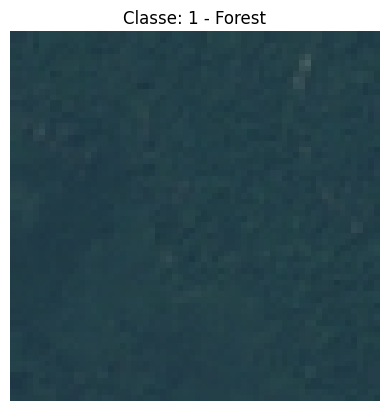

Nome da classe: Forest


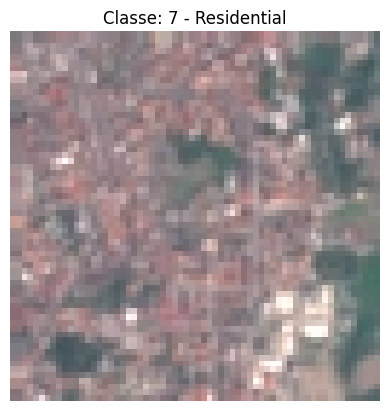

Nome da classe: Residential


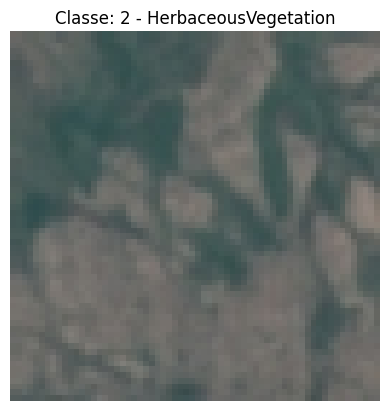

Nome da classe: HerbaceousVegetation


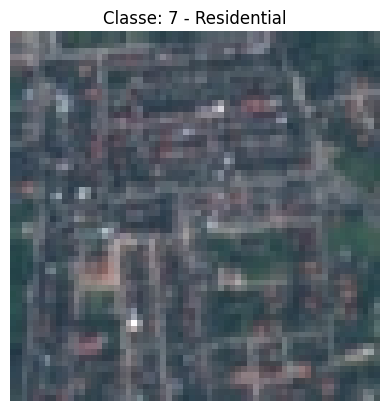

Nome da classe: Residential


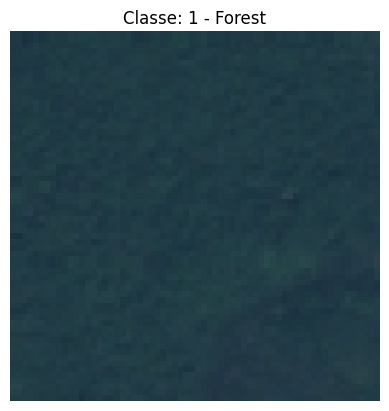

Nome da classe: Forest


In [ ]:
# Itera no conjunto de dados pegando exemplos
# Inclua seu código aqui (~5 linhas)
for image, label in train_data.take(5):
    plt.figure()
    plt.imshow(image.numpy())  # Exibe a imagem
    plt.title(f"Classe: {label} - {labels_list[label.numpy()]}")
    plt.axis('off')  # Remove os eixos para melhor visualização
    plt.show()

    print('Nome da classe:', labels_list[label])

**Exemplo de saída esperada (sem as figuras):**

    Classe: Forest - 1
    Classe: Residential - 7
    Classe: River - 8
    


## 3. Processamento dos dados

Após carregar os dados, você tem que processá-los para poderem ser usados pela RNA.

O módulo de vetores de características da EfficientNet permite que as imagens tenham em princípio qualquer dimensão, assim, não é necessário redimensionar as imagens. Porém, os valores dos pixels devem estar entre 0 e 1, conforme mencionado nas instruções de uso desse módulo, que podem ser vistas em https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1.

### Exercício #3: Normalização das imagens

Na célula abaixo escreva um código para normalizar um lote de imagens e depois crie os lotes de dados de treinamento e de validação.

Conforme vimos na aula, ao importar os dados do TF Data Services, os dados são armazenados em objetos e para podermos usar esses dados de forma eficiente temos que usar os métodos fornecidos para esse tipo de objeto.

Para normalizar e redimensionar as imagens crie uma função de nome `format_image` e a utilize chamando o método `map()`.

A dimensão das imagens deve ser 64x64 pixels.

Para normalizar os dados você vai precisar primeiramente transformá-los em `float32`, para isso use a função `tf.cast()`. As instruções de uso dessa função podem ser vistas em https://www.tensorflow.org/api_docs/python/tf/cast.

Crie um dataset eficiente, para isso utilize processamento em paralelo quando executar a função de pré-processamento dos dados. Use tamném os métodos `cache` e `prefetch`.

In [ ]:
# Definição da dimensão das imagens para processamento e do tamanho dos lotes de dados

# Use otimização do pipeline
AUTOTUNE = tf.data.AUTOTUNE

# Inclua seu código aqui (~2 linhas)
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

# Função usada para redimensionar e normalizar as imagens
# Inclua seu código aqui (~3 linhas)
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)  # Redimensiona a imagem para 64x64 pixels
    image = tf.cast(image, tf.float32) / 255.0  # Normaliza os valores dos pixels para [0, 1]
    return image, label

# Cria lotes de dados usando o método map() para chamar a função format_image()
# Inclua seu código aqui (~2 linhas)
train_batches = train_data.map(format_image, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_batches = val_data.map(format_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**Saída espeada:**

    <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>  

Execute a célula abixo para verificar se o seu dataset está correto.

In [ ]:
for img, label in train_batches.take(1):
    print('Dimensão de um lote de imagens:', img.shape)
    print('Dimensão de um lote de saídas desejadas:', label.shape)

Dimensão de um lote de imagens: (32, 64, 64, 3)
Dimensão de um lote de saídas desejadas: (32,)


**Saída esperada:**

    Dimensão de um lote de imagens: (32, 64, 64, 3)
    Dimensão de um lote de saídas desejadas: (32,)

## 4.  Criação da RNA

Nesse trabalho você vai criar e treinar uma RNA para identificar tipos de áreas a partir de imagens do satélite Sentinel-2.

Para isso você vai criar uma RNA usando como base o módulo de vetor de características da rede EfficientNet, que foi treinada com as imagens da ImageNet.

As redes EfficientNets são utilizadas para classificar imagens e apresentam um desempenho similar a outras redes mais conhecidas, porém, possui um número muito menor de parâmetros e é muito mais rápida. O trabalho que originou essa RNA é
Mingxing Tan and Quoc V. Le: EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks, ICML 2019.

### Exercício #4: Carregar vetor de características do TF-Hub

Na célula abaixo crie um código que importa o módulo de vetores de características da EfficientNet e o coloca no objeto `feature_extractor`. Essa rede estão no TF-Hub e as informações de como usá-la podem ser obtidas no link https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1.

Pra fazer isso você vai precisar definir a dimensão do tensor de entrada da rede usando o argumento `input_shape` e a função `hub.KerasLayer()`.

In [ ]:
# Dimensão das imagens para argumento input_shape
# Inclua seu código aqui (~1 linha)
input_shape = (64, 64, 3)

# Carrega vetores de características com a URL do módulo
# Inclua seu código aqui (~2 linhas)
feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
feature_extractor = hub.KerasLayer(feature_extractor_url, input_shape=input_shape, trainable=False) # para nao retreinar o modelo importado

feature_extractor

**Saída espeada:**

    <tensorflow_hub.keras_layer.KerasLayer at 0x7ff58df7ae48>

Execute a célula abaixo para verificar os seus resultados.

In [ ]:
for img, label in train_batches.take(2):
    feat = feature_extractor(img)
    print(feat.shape)

(32, 1280)
(32, 1280)


**Saída esperada:**

    (32, 1280)
    (32, 1280)

### Exercício #5: Criação da RNA como o Keras

Na célula abaixo crie um código que incorpora o `feature_extractor`, criado no exercício #4, em uma rede sequencial do Keras para realizar a tarefa de classificação multiclasse com 10 classes.

Após criar a RNA utilize o método `summary()` para apresentá-la.

In [ ]:
# Número de classes da RNA
# Inclua seu código aqui (~1 linha)
classes = 10

# Cria modelo seguencial do Keras para problema de classificação com 10 classes
# Inclua seu código aqui (~3 linhas)
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    feature_extractor,
    keras.layers.Dense(classes, activation='softmax')  # Camada de saída para classificação em 10 classes
])

# Apresenta configuração da RNA
# Inclua seu código aqui (~1 linha)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


**Saída esperada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    keras_layer (KerasLayer)     (None, 1280)              4049564   
    _________________________________________________________________
    dense (Dense)                (None, 10)                12810     
    =================================================================
    Total params: 4,062,374
    Trainable params: 12,810
    Non-trainable params: 4,049,564
    _________________________________________________________________

## 5. Compilação e treinamento da RNA

Como visto em aula, o treinamento da RNA deve ser realizado de forma que somente os parâmetros da camada densa, adicionada ao extrator de características, sejam alterados durante o treinamento. Isso é necessário para não destrui a parte da RNA que corresponde à EfficientNet, que já foi previamente treinada com um conjunto de centenas de milhares de imagens. Assim, você tem que "congelar" os parâmetros do extrator e características.

### Exercício #6: Compilação da RNA

Na célula abaixo crie um código que congela os parâmetros do `feature_extractor` e compila a RNA usando os seguintes parâmetros:

- Método de otimização: Adam;
- Fução de custo: `sparse_categorical_crossentropy`;
- Métrica: `accuracy`.

In [ ]:
# Congela parâmetros da MobiliNet
# Inclua seu código aqui (~1 linha)

#ja havia feito na importação do modelo com trainable=False, mas vamos refazer
feature_extractor.trainable=False

# Define método de otimização
# Inclua seu código aqui (~1 linha)
optimizer = keras.optimizers.Adam()

# Compila RNA
# Inclua seu código aqui (~1 comando)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo compilado com sucesso.")


Modelo compilado com sucesso.


### Exercício #7: Treinamento da RNA

O treinamento da RNA deve ser realizado com o método `fit` e os dados de treinamento e validação são fornecidos por meio dos objetos `train_batches` e `val_batches`.

Na célula abaixo crie um código que realiza o treinameto da RNA usando 30 épocas de treinamento.

In [ ]:
# Define número de épocas de treinamento
# Inclua seu código aqui (~1 linha)
epocas = 30

# Realiza o treinamento usando os dados de treinamento e validação
# Inclua seu código aqui (~1 comando)
history = model.fit(train_batches,
                    epochs=epocas,
                    validation_data=val_batches)

Epoch 1/30
675/675 [==============================] - 21s 18ms/step - loss: 0.5009 - accuracy: 0.8537 - val_loss: 0.3044 - val_accuracy: 0.9046
Epoch 2/30
675/675 [==============================] - 9s 14ms/step - loss: 0.2677 - accuracy: 0.9148 - val_loss: 0.2611 - val_accuracy: 0.9152
Epoch 3/30
675/675 [==============================] - 8s 12ms/step - loss: 0.2250 - accuracy: 0.9286 - val_loss: 0.2446 - val_accuracy: 0.9200
Epoch 4/30
675/675 [==============================] - 13s 19ms/step - loss: 0.2000 - accuracy: 0.9362 - val_loss: 0.2363 - val_accuracy: 0.9224
Epoch 5/30
675/675 [==============================] - 15s 23ms/step - loss: 0.1822 - accuracy: 0.9423 - val_loss: 0.2317 - val_accuracy: 0.9248
Epoch 6/30
675/675 [==============================] - 10s 15ms/step - loss: 0.1685 - accuracy: 0.9466 - val_loss: 0.2292 - val_accuracy: 0.9244
Epoch 7/30
675/675 [==============================] - 9s 14ms/step - loss: 0.1574 - accuracy: 0.9506 - val_loss: 0.2280 - val_accuracy: 0.

**Saída esperada:**

    Epoch 1/10
    675/675 [==============================] - 13s 19ms/step - loss: 0.5030 - accuracy: 0.8542 - val_loss: 0.3120 - val_accuracy: 0.9002
    .
    .
    .
    Epoch 30/30
    675/675 [==============================] - 8s 11ms/step - loss: 0.0695 - accuracy: 0.9830 - val_loss: 0.2688 - val_accuracy: 0.9181

### Exercício #8: Resultados do treinamento

Na célula abaixo crie um código que apresenta os resultados do treinamento em função das épocas. Você deve fazer dois gráficos:

1. Valores da função de custo para os dados de treinamento e de validação;
2. Valores da métrica para os dados de treinamento e de validação.

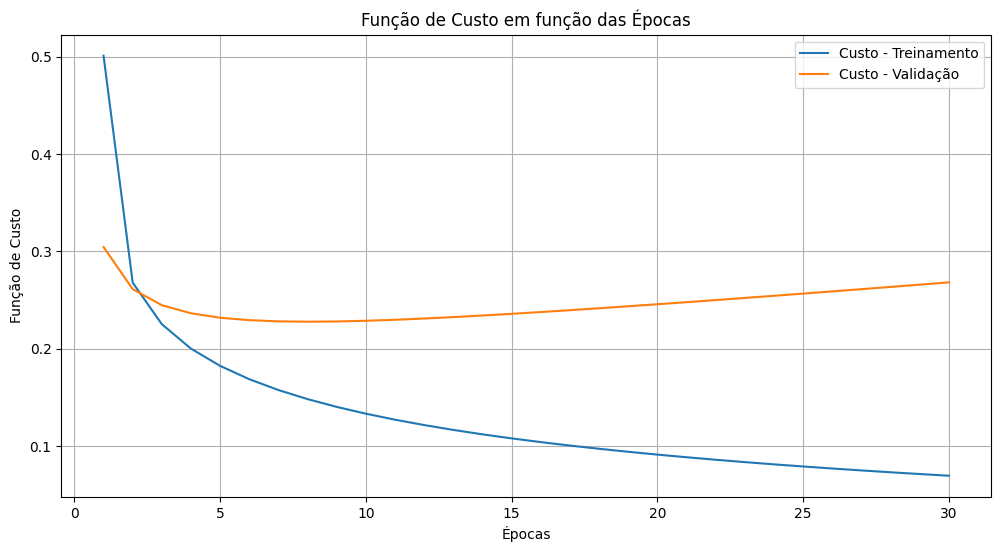

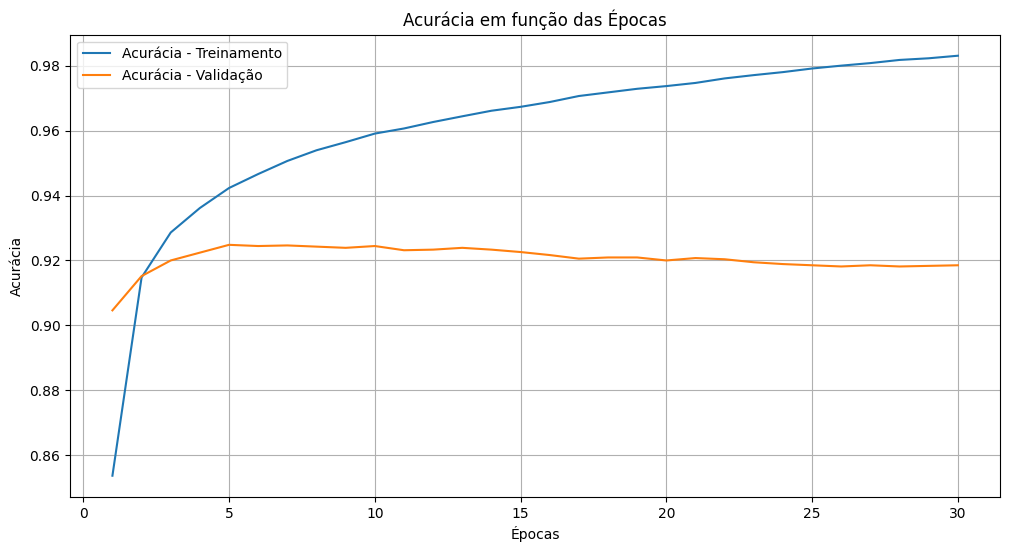

In [ ]:
# Definir vetores com valores da função de custo e da métrica para os dados de treinamento e de validação
# Inclua seu código aqui (~5 linhas)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


# Criar vetor de épocas
# Inclua seu código aqui (~1 linha)
epochs_range = range(1, epocas + 1)

# Fazer o gráfico dos valores da função de custo
# Inclua seu código aqui (~6 linhas)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Custo - Treinamento')
plt.plot(epochs_range, val_loss, label='Custo - Validação')
plt.title('Função de Custo em função das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Função de Custo')
plt.legend()
plt.grid(True)
plt.show()


# Fazer o gráfico dos valores da métrica
# Inclua seu código aqui (~6 linhas)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label='Acurácia - Treinamento')
plt.plot(epochs_range, val_accuracy, label='Acurácia - Validação')
plt.title('Acurácia em função das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()



## 6.4 Teste da RNA

Após o treinamento é necessário verificar o desempenho da RNA. paar isso vamos calcular os valores da função de custo e da métrica para as imagens do conjunto de validação e depois vamos usar o método `predict` para prever as classes de algumas imagens.

O código da célula abaixo calcula o resultado da função de custo e da exatidão para os exemplos validação usando o método `evaluate`.

### Exercício #9: Avaliação do desempenho da RNA

Na célula abaixo determine o desemepnho da RNA usando o método `evaluate` para calcular o valor da função d ecusto e da métrica para os dados de validação.

In [ ]:
# Avalia desempenho da RNA para os dados de validação
# Inclua seu código aqui (~1 linha)
eval_results = model.evaluate(val_batches, verbose=0)


# Apresenta os resultados
# Inclua seu código aqui (~2 linhas)
for metric, value in zip(model.metrics_names, eval_results):
    print(metric + ': {:.4}'.format(value))

loss: 0.2681
accuracy: 0.9185


**Saída esperada:**

    loss: 0.2684
    accuracy: 0.9181

### Exercício #10: Teste de classificação de imagens

Para poder fornecer as imagens para a RNA usando o método `predict` você precisa extrai-las do objeto `val_data` e processá-las com a função `format_image`, que por sua vez é chamada pelo método `map()`. Além disso, você tem que incluir o eixo dos exemplos na imagem de acordo com o esperado por uma RNA do Keras.

Na célula baixo crie um código que calcula as classes previstas para os 5 primeiros exemplos do conjunto de validação usando o método `predict` e apresenta os resultados junto com as imagens e as classes previstas e reais.

1/1 [==============================] - 2s 2s/step

Probabilidades = [[1.1527305e-03 7.3272453e-08 7.7192162e-05 1.7564749e-05 4.1921544e-10
  9.9665242e-01 2.0986279e-03 2.4821127e-09 1.3877227e-06 1.6185253e-12]]
Classe prevista =  Pasture  , Classe real =  Pasture


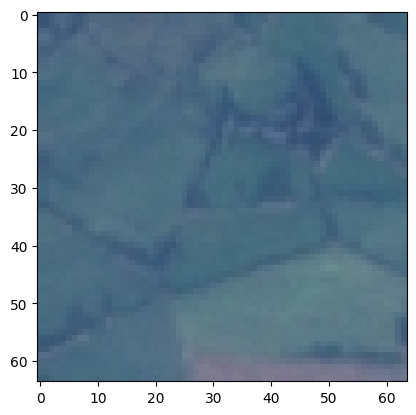

1/1 [==============================] - 0s 32ms/step

Probabilidades = [[2.9181578e-07 7.1272974e-09 1.4946512e-07 3.7114071e-07 9.1965143e-07
  1.1777808e-08 4.9931173e-06 9.9999321e-01 2.1085958e-11 2.0623204e-08]]
Classe prevista =  Residential  , Classe real =  Residential


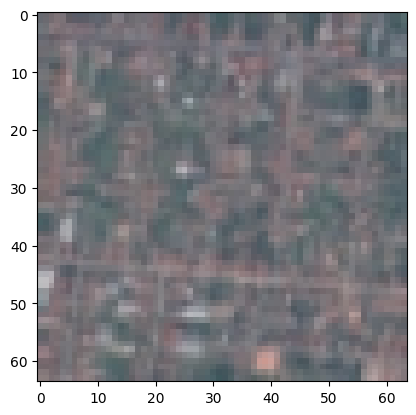

1/1 [==============================] - 0s 32ms/step

Probabilidades = [[9.9928743e-01 3.8331621e-10 1.3544016e-09 1.2701661e-04 2.2022550e-09
  5.6667970e-10 5.8566069e-04 1.2285504e-13 2.8355519e-08 2.8170760e-13]]
Classe prevista =  AnnualCrop  , Classe real =  AnnualCrop


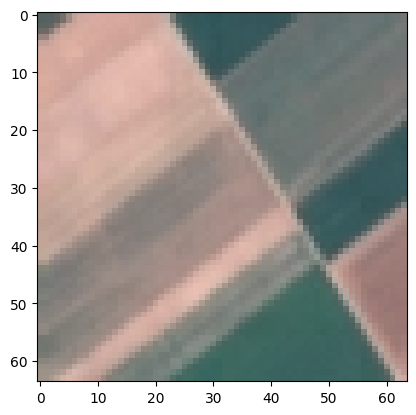

1/1 [==============================] - 0s 26ms/step

Probabilidades = [[2.8253755e-05 9.8996466e-01 9.9581826e-05 1.6946184e-05 1.4926884e-07
  8.8491105e-03 1.3979669e-06 1.2357009e-04 4.3271019e-04 4.8376489e-04]]
Classe prevista =  Forest  , Classe real =  Forest


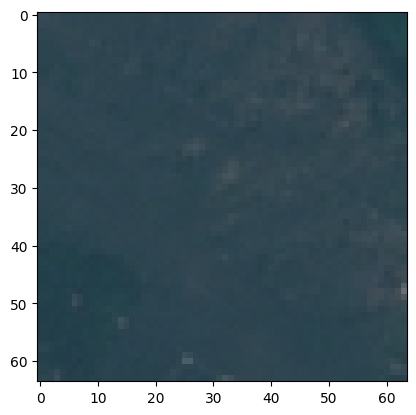

1/1 [==============================] - 0s 40ms/step

Probabilidades = [[9.9888223e-01 2.5226798e-06 2.1749182e-04 2.2736867e-06 5.6303031e-07
  2.7840565e-09 1.7841370e-04 6.6300773e-04 5.3498439e-05 6.9930861e-09]]
Classe prevista =  AnnualCrop  , Classe real =  AnnualCrop


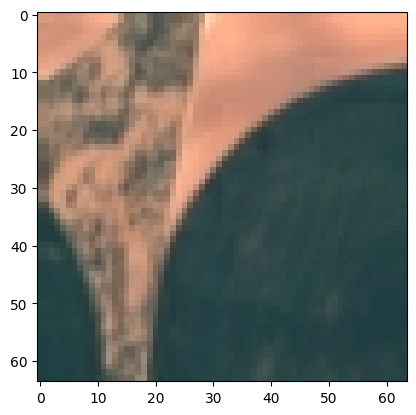

In [ ]:
# Itera no objeto val_data para pegar 5 imagens e aplica função format_image
for data in val_data.map(format_image).take(5):

    # Extrai imagem e classe prevista
    # Inclua seu código aqui (~1 linha)
    image, label = data

    # Adiciona eixo dos exemplos
    # Inclua seu código aqui (~1 linha)
    image = np.expand_dims(image, axis=0)

    # Calcula probabilidades previstas pela RNA
    # Inclua seu código aqui (~1 linha)
    yprev = model.predict(image)

    # Determina classe prevista
    # Inclua seu código aqui (~1 linha)
    classe_prev = np.argmax(yprev)

    # Apresenta resultados das classes e mostra imagem
    # Inclua seu código aqui (~4 linhas)
    print('\nProbabilidades =', yprev)
    print("Classe prevista = ", labels_list[classe_prev], " , Classe real = ", labels_list[label])
    plt.imshow(image[0])
    plt.show()


**Saída esperada (sem incluir as imagens):**

    Classe prevista = Industrial , Classe real = Industrial
    Classe prevista = AnnualCrop , Classe real = AnnualCrop
    Classe prevista = HerbaceousVegetation , Classe real = HerbaceousVegetation
    Classe prevista = River , Classe real = River
    Classe prevista = Residential , Classe real = Residential